In [2]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       # Data Formatting


In [3]:
plt.rcParams['figure.figsize'] = [12, 8]

### Read Catalog
- This reads the master reference catalog file for the hackathon
- Data which is available has to be at 'NERSC' or 'online'

In [4]:
# Final location (once updated)
#catfn='https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml'
# Interim Repo location
catfn='https://raw.githubusercontent.com/digital-earths-global-hackathon/catalog/refs/heads/scream-final2/catalog.yaml'

scream_cat = intake.open_catalog(catfn)

print (list (scream_cat)) 

['EU', 'NERSC', 'online']


In [5]:
# List different 'types' of data
print (list (scream_cat.NERSC)) 
#print (list (scream_cat.online))

['scream2D_hrly', 'scream_ne120', 'scream_lnd']


### Read 3D SCREAM Data

### Combined ne120 (2D and 3D)

In [6]:
z=6
ds3hr = scream_cat.NERSC.scream_ne120(zoom=z).to_dask()
ds3hr = ds3hr.pipe(egh.attach_coords)
ds3hr.time

/global/homes/a/agett/.conda/envs/hk25env/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.DataArray 'time' (time: 3168)> Size: 25kB
array([cftime.DatetimeNoLeap(2019, 8, 1, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 8, 1, 6, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 8, 1, 9, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2020, 8, 31, 18, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 8, 31, 21, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 9, 1, 0, 0, 0, 0, has_year_zero=True)],
      shape=(3168,), dtype=object)
Coordinates:
  * time     (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00:00:00
    crs      int64 8B 0
Attributes:
    bounds:     time_bnds
    long_name:  time

#### Plot 2D

Text(0.5, 1.0, 'SCREAM tas 2020-01-05 HEALPix Level 6')

<Figure size 1200x800 with 0 Axes>

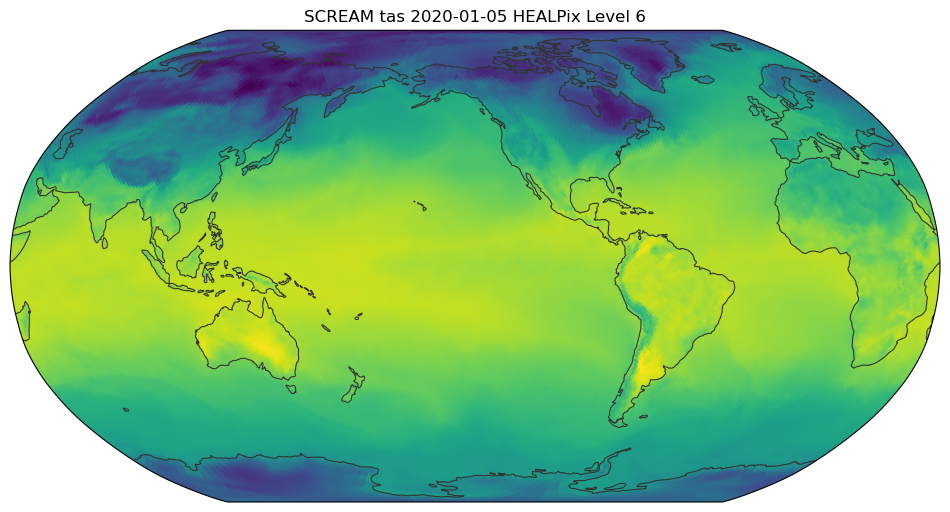

In [7]:
vart='tas'
tm='2020-01-05'
tmp=ds3hr[vart].sel(time=tm)[0]

egh.healpix_show(tmp)
plt.title('SCREAM '+vart+' '+tm+' HEALPix Level '+str(z))

#### Plot 3D

CPU times: user 271 ms, sys: 181 ms, total: 453 ms
Wall time: 295 ms


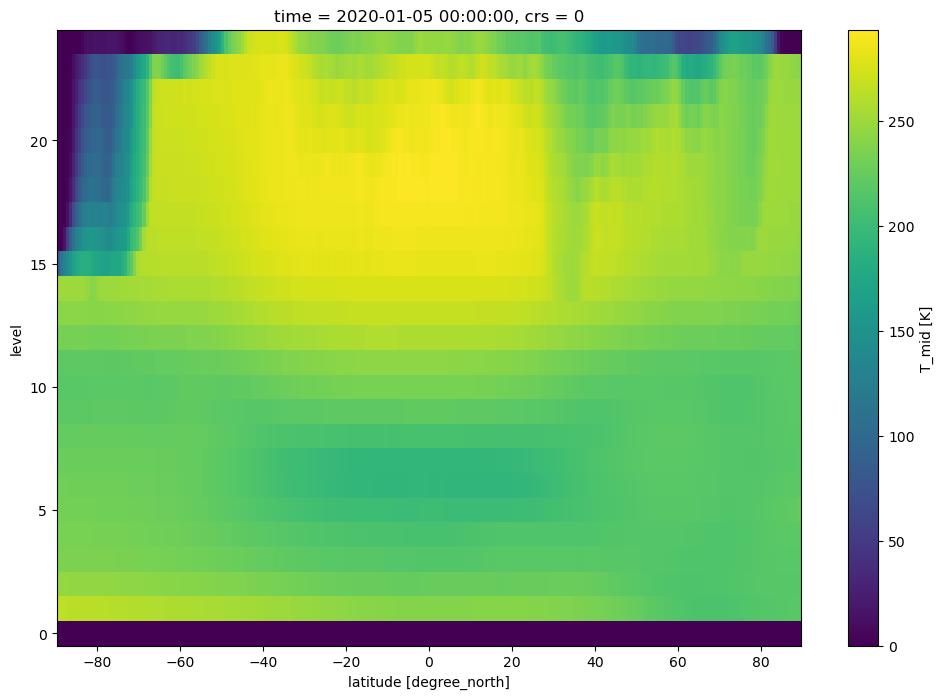

In [8]:
%%time

vt='ta'
tm='2020-01-05'
tmp=ds3hr[vt].sel(time=tm)[0]

zm = (
    tmp
    .groupby("lat")
    .mean()
).compute()

zm.plot()

### 2D hourly
Catalog entry with Multiple zarr files for variables merged

In [9]:
z=10
ds_hr = scream_cat.NERSC.scream2D_hrly(zoom=z).to_dask()
ds_hr = ds_hr.pipe(egh.attach_coords)
ds_hr

/global/homes/a/agett/.conda/envs/hk25env/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 952GB
Dimensions:  (time: 9457, cell: 12582912)
Coordinates:
  * time     (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    lat      (cell) float64 101MB 0.0373 0.0746 0.0746 ... -0.0746 -0.0373
    lon      (cell) float64 101MB 45.0 45.04 44.96 45.0 ... 315.0 315.0 315.0
Data variables:
    pr       (time, cell) float32 476GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut     (time, cell) float32 476GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

In [10]:
vt='rlut'

Text(0.5, 1.0, 'SCREAM rlut 2020-01-05 HEALPix Level 10')

<Figure size 1200x800 with 0 Axes>

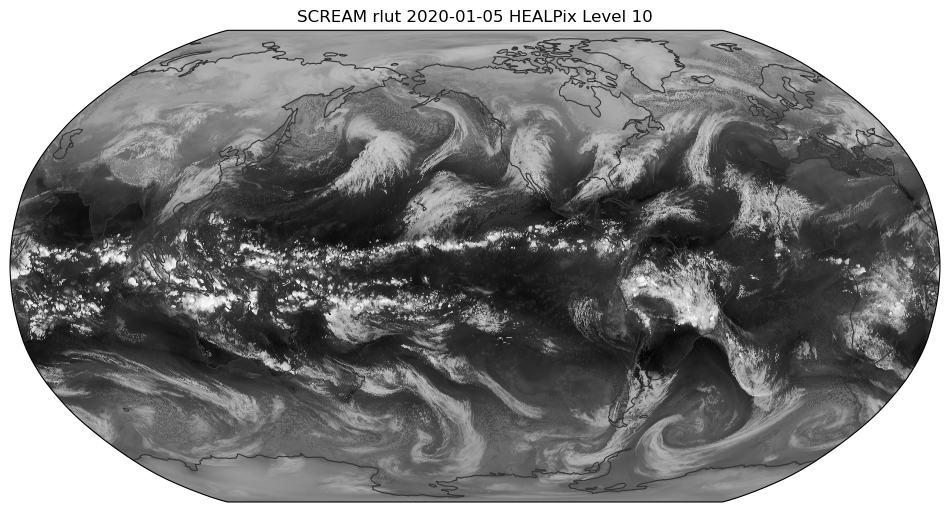

In [11]:
tm='2020-01-05'
tmp=ds_hr[vt].sel(time=tm)[0]

egh.healpix_show(tmp,cmap='binary')
plt.title('SCREAM '+vt+' '+tm+' HEALPix Level '+str(z))

### Regional Plot

CPU times: user 265 ms, sys: 151 ms, total: 416 ms
Wall time: 318 ms


/global/homes/a/agett/.conda/envs/hk25env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0.5, 1.0, 'SCREAM tas 2020-01-05 HEALPix Level 10')

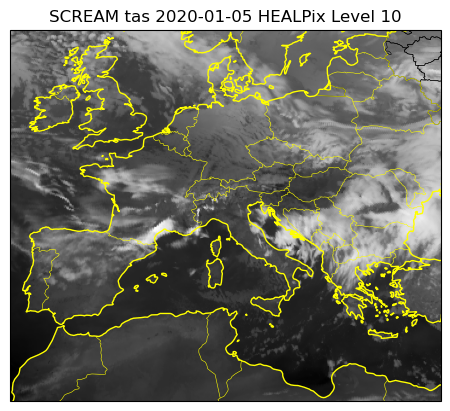

In [16]:
%%time
projection = ccrs.Robinson(central_longitude=10)
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
#Europe
ax.set_extent([-10, 30, 30, 60], crs=ccrs.PlateCarree())

#W. US
#ax.set_extent([-130, -110, 30, 50], crs=ccrs.PlateCarree())

#N. CA

#ax.set_extent([-124, -122, 37, 40], crs=ccrs.PlateCarree())

tm2='2020-01-05'

egh.healpix_show(ds_hr[vt].sel(time=tm2)[0],ax=ax,cmap='binary')
ax.add_feature(cf.STATES, linewidth=0.4)
ax.add_feature(cf.BORDERS, linewidth=0.4,color='yellow')
ax.add_feature(cf.COASTLINE, linewidth=1.,color='yellow')
plt.title('SCREAM '+vart+' '+tm2+' HEALPix Level '+str(z))

In [22]:
%%time

vt="rlut"

Slim, Nlim = 15.0, 35.0
t1, t2 = "2020-02-01", "2020-03-01"
da_by_lon = (
    ds_hr[vt]
    .sel(time=slice(t1, t2))
    .where((ds_hr["lat"] > Slim) & (ds_hr["lat"] < Nlim),drop=True)
    .groupby("lon")
    .mean()
).compute()

CPU times: user 56.5 s, sys: 1min 30s, total: 2min 27s
Wall time: 18.8 s


<unknown>:4: SyntaxWarning: invalid escape sequence '\c'
<unknown>:4: SyntaxWarning: invalid escape sequence '\c'


CPU times: user 572 ms, sys: 100 ms, total: 673 ms
Wall time: 673 ms


Text(0, 0.5, 'Day of Year')

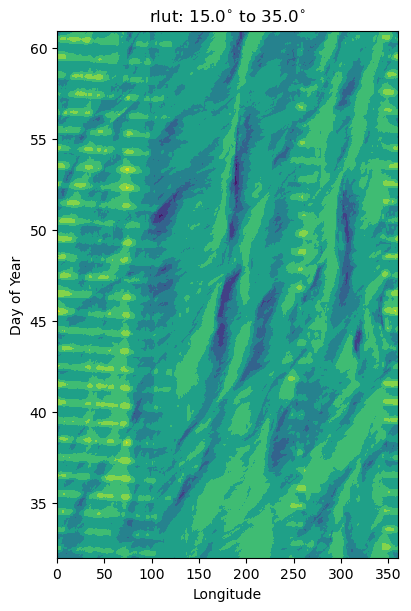

In [26]:
%%time
days=ds_hr.time.dt.dayofyear+ds_hr.time.dt.hour/24.
fig, ax = plt.subplots(figsize=(4, 6), constrained_layout=True)
plt.contourf(da_by_lon.lon,days.sel(time=slice(t1, t2)),da_by_lon)
ax.set_title(f"{vt}: {Slim}$^{{\circ}}$ to {Nlim}$^{{\circ}}$")
plt.xlabel("Longitude")
plt.ylabel("Day of Year")

### Land Variables

In [17]:
z=8
ds_lnd = scream_cat.NERSC.scream_lnd(zoom=z).to_dask()
ds_lnd= ds_lnd.pipe(egh.attach_coords)
ds_lnd

/global/homes/a/agett/.conda/envs/hk25env/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 397, cell: 786432)
Coordinates:
  * time     (time) object 3kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 6MB 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
    lat      (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.2984 -0.1492
    lon      (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Data variables:
    mrso     (time, cell) float32 1GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    swe      (time, cell) float32 1GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
Attributes: (12/27)
    Conventions:                               CF-1.7
    Initial_conditions_dataset:                20220928.I2010CRUELM.ne1024pg2...
    PFT_physiological_constants_dataset:       clm_params_c180301.nc
    Surface_dataset:                           surfdata_ne1024pg2_simyr2010_c...
    case:                                      cess-control.ne1024pg2_ne1024p...
    comment:                                   NOTE: None of the variables ar...
    ...                                        ...
    product:                                   model-output
    realm:                                     land
    source:                                    E3SM Land Model
    source_id:                                 f4f0672bb4
    title:                                     ELM History file information
    username:                                  noel

In [18]:
#ds_lnd.time[0:10]

Text(0.5, 1.0, 'SCREAM mrso 2020-01-05 HEALPix Level 8')

<Figure size 1200x800 with 0 Axes>

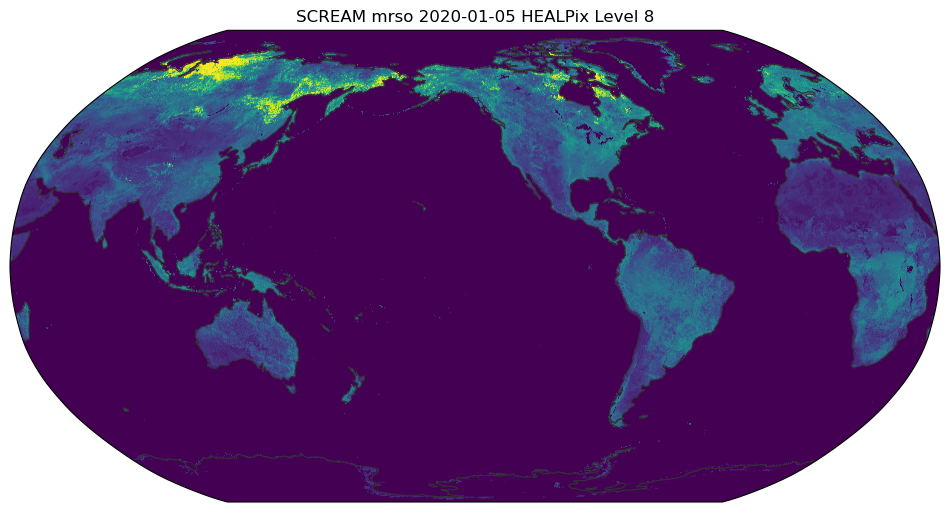

In [19]:
vt='mrso'
tm='2020-01-05'
tmp=ds_lnd[vt].sel(time=tm)[0]

egh.healpix_show(tmp)
plt.title('SCREAM '+vt+' '+tm+' HEALPix Level '+str(z))